In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib.pyplot as plt

In [2]:
from tensorflow import keras
from tensorflow.keras import layers

import tensorflow as tf

import tsgm

We want to generate a temporal dataset where each time series belongs to one of two classes. Let's go step by step through the solution.

#### 1. Define parameters of GAN:
First, we are defining the parameters of GAN, and the training algorithm.
- `latent_dim` is the size of input noise in GAN,
- `num_classes` is the number of classes, which, mentioned above is two,
- `feature_dim` is the number of time series features,
- `seq_len` is the length of the time series.

In [3]:
latent_dim = 64
num_classes = 2
feature_dim = 1
seq_len = 100
batch_size = 128


generator_in_channels = latent_dim + num_classes
discriminator_in_channels = feature_dim + num_classes

#### 2. Load data:
We are working with a toy dataset, and use `tsgm` utility called `tsgm.utils.gen_sine_vs_const_dataset` to generate the data. Next, we featurewise scale the dataset so that each feature is in $[-1, 1]$, using `tsgm.utils.TSFeatureWiseScaler`.

In [6]:
X, y_i = tsgm.utils.gen_sine_vs_const_dataset(5_000, seq_len, 1, max_value=20, const=10)

scaler = tsgm.utils.TSFeatureWiseScaler((-1, 1))
X_train = scaler.fit_transform(X)
y = keras.utils.to_categorical(y_i, 2)

X_train = X_train.astype(np.float32)
y = y.astype(np.float32)

dataset = tf.data.Dataset.from_tensor_slices((X_train, y))
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

#### 3. Visually explore the dataset.
There are many tools for convenient visualizations of temporal datasets. Here, we use `tsgm.utils.visualize_ts_lineplot`, which is convenient for TS classification datasets.

1
1
0
1
1


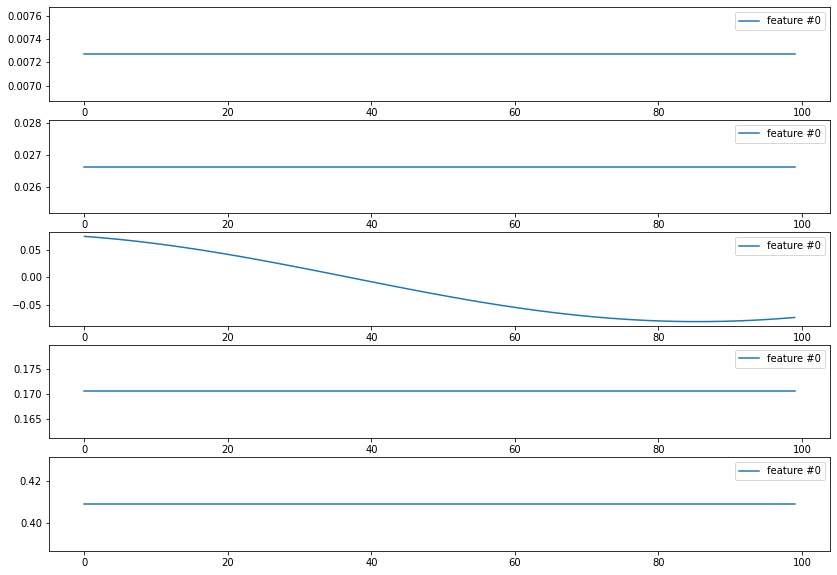

In [7]:
tsgm.utils.visualize_ts_lineplot(X_train, y_i)

#### 4. Choose architecture.
Here, you can either use one of the architectures presented in `tsgm.models.architectures`, or define custom discriminator and generator architectures as `tf` models.

In [11]:
architecture = tsgm.models.architectures.zoo["cgan_base_c4_l1"](
    seq_len=seq_len, feat_dim=feature_dim,
    latent_dim=latent_dim, num_classes=num_classes)
discriminator, generator = architecture.discriminator, architecture.generator

#### 5. Define model and train it.
We define conditional GAN model (`tsgm.models.cgan.ConditionalGAN`), compile it (here, you can choose different optimizers for discriminator and generator), and train using `.fit` model. Additionally, we use `tsgm.models.monitors.GANMonitor` to track training process.

In [12]:
cond_gan = tsgm.models.cgan.ConditionalGAN(
    discriminator=discriminator, generator=generator, latent_dim=latent_dim
)
cond_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

cbk = tsgm.models.monitors.GANMonitor(num_samples=3, latent_dim=latent_dim, save=False, labels=y, save_path="/tmp")
cond_gan.fit(dataset, epochs=1000, callbacks=[cbk])

Epoch 1/1000


TypeError: in user code:

    File "/Users/e102949/Projects/open_source/tsgm/venv/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/Users/e102949/Projects/open_source/tsgm/venv/lib/python3.9/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/e102949/Projects/open_source/tsgm/venv/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/Users/e102949/Projects/open_source/tsgm/tsgm/models/cgan.py", line 287, in train_step
        dp = isinstance()

    TypeError: isinstance expected 2 arguments, got 0


#### 6. Visualize the results.
Now, we can generate samples from the model, and visualize them. A convinient way to visualize them is to use [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) via `tsgm.utils.visualize_tsne`.

In [ ]:
limit = 500
X_gen = cond_gan.generate(y[:limit])
X_gen = X_gen.numpy()
y_gen = y[:limit]

In [ ]:
tsgm.utils.visualize_tsne(X_train[:limit], y[:limit], X_gen, y_gen)